# Lab 2 : Visibility Graphs
---

# Import Dependencies

In [183]:
from matplotlib import pyplot as plt
from matplotlib import path
import numpy as np
import sys
import csv
import math
import time

## Point Class

In [184]:
class Point:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y
    
    def dist(self, p):
        # Distance between point self and point p
        return math.sqrt((self.x - p.x)**2 + (self.y - p.y)**2)
    
    def numpy(self):
        # return the point (x, y) as a numpy array
        return np.array([self.x, self.y])
        
    def dist_line(self, l):
        # return the distance between point self an line l of type Segment.
        return np.linalg.norm(np.cross(l.p2.numpy() - l.p1.numpy(), l.p1.numpy() - self.numpy())) / np.linalg.norm(l.p2.numpy() - l.p1.numpy())

    def __str__(self):
        # returns point self as a string
        return "({}, {})".format(np.round(self.x, 2), np.round(self.y, 2))

    def dot(self, p):
        # Dot product
        return self.x * p.x + self.y*p.y

    def length(self):
        # returns modulus of point self
        return math.sqrt(self.x**2 + self.y**2)

    def vector(self, p):
        # creates a vector of type Point between point self and point p
        return Point(p.x - self.x, p.y - self.y)

    def unit(self):
        # makes the point self unitary if possible
        mag = self.length()
        if mag > 0:
            return Point(self.x/mag, self.y/mag)
        else:
            return Point(0, 0)

    def scale(self, sc):
        # multiplies point self by scalar sc
        return Point(self.x * sc, self.y * sc)

    def __add__(self, p):
        # add point self and point p component by component
        return Point(self.x + p.x, self.y + p.y)

    def __sub__(self, p):
        # substracts point self and point p component by component
        return Point(self.x - p.x, self.y - p.y)

    def __truediv__(self, s):
        # divides point self by scalar s
        return Point(self.x / s, self.y / s)
    
    def __floordiv__(self, s):
        # integer division of point self by scalar s
        return Point(int(self.x / s), int(self.y / s))
    
    def __mul__(self, s):
        return Point(self.x * s, self.y * s)
    
    def __rmul__(self, s):
        return self.__mul__(s)
    
    def __eq__(self, __o: object) -> bool:
        if abs(self.x - __o.x) < 0.0001 and abs(self.y - __o.y) < 0.0001:
            return True
        return False 

    def ccw(self, A, B, C):
        return (C.y - A.y) * (B.x - A.x) >= (B.y - A.y) * (C.x - A.x)

    def det(self, a, b):
        return a[0] * b[1] - a[1] * b[0]



# Segment Class

In [185]:
class Segment:
    def __init__(self, p1=Point(), p2=Point(), id=0):
        # A segment is defined by two Point objects
        self.p1 = p1
        self.p2 = p2
        self.id = id

    @classmethod
    def point_angle_length(cls, p1=Point(), angle=0, length=1):
        # A segment can be initialized with a Point object, an angle, and a segment length.
        x2 = p1.x + math.cos(angle) * length
        y2 = p1.y + math.sin(angle) * length
        return cls(p1, Point(x2, y2))
        
    def intersect(self, s):
        # Return true if Segment self and Segment s intersect
        if self.ccw(self.p1, s.p1, s.p2) != self.ccw(self.p2, s.p1, s.p2) and self.ccw(self.p1, self.p2, s.p1) != self.ccw(self.p1, self.p2, s.p2):
            p = self.intersection_point(s)
            if p == self.p1 or p == self.p2:
                return False, None
            else:
                return True, p
        else:
            return False, None

    def intersection_point(self, line):
        # Returns the point in which line Segment self and line Segment s intersect
        xdiff = (self.p1.x - self.p2.x, line.p1.x - line.p2.x)
        ydiff = (self.p1.y - self.p2.y, line.p1.y - line.p2.y)

        div = self.det(xdiff, ydiff)
        if div == 0:
            print("Something went wrong!")
            return None

        d = (self.det((self.p1.x, self.p1.y), (self.p2.x, self.p2.y)), self.det((line.p1.x, line.p1.y), (line.p2.x, line.p2.y)))
        x = self.det(d, xdiff) / div
        y = self.det(d, ydiff) / div
        return Point(x, y)
    
    def is_same_segment(self, s):
        if [self.p1.x, self.p1.y] ==  [s.p1.x, s.p1.y] or [self.p1.x, self.p1.y] ==  [s.p2.x, s.p2.y]:
            if [self.p2.x, self.p2.y] ==  [s.p1.x, s.p1.y] or [self.p2.x, self.p2.y] ==  [s.p2.x, s.p2.y]:
                return True
            else:
                return False
        else:
            return False
        
    def is_contain(self, p):
        if [self.p1.x, self.p1.y] ==  [p.x, p.y] or [self.p2.x, self.p2.y] ==  [p.x, p.y]:
            return True
        else:
            return False

    def __str__(self):
        return "[{}, {}]".format(self.p1, self.p2)
    
    def ccw(self,A, B, C):
        return (C.y - A.y) * (B.x - A.x) >= (B.y - A.y) * (C.x - A.x)

    def det(self,a, b):
        return a[0] * b[1] - a[1] * b[0]


# Vertex Class

In [186]:
class Vertex:
    """
    Vertex Class wtih information of associate edge and polygon
    """
    def __init__(self, p=Point(), e1=Segment(), e2=Segment() ,id=0, polygon_id=0):
        self.p = p
        self.e1 = e1
        self.e2 = e2
        self.id = id
        self.polygon_id = polygon_id

    def get_edge(self):
        if self.e1.id == 0:
            e1 = None
            e2 = None
        else:
            e1 = self.e1
            e2 = self.e2

        return e1, e2

    def is_share_edge(self, vi):
         """
        Check if vertex share the same edge with vi 
        """
         if  self.e1.id == 0 or  not self.e2.id == 0:
             return False
         elif self.e1.is_same_segment(vi.e1) or self.e1.is_same_segment(vi.e2) or self.e2.is_same_segment(vi.e1) or self.e2.is_same_segment(vi.e2):
             return True
         else:
             return False
        
    

# Ploygon Class

In [187]:
class Polygon:
    """
    Containing the id and segments of each polygon
    Mainly for checking if the segment is in polygon
    """
    def __init__(self, segments= [],id=0):
        # A segment is defined by two Point objects
        self.segments = segments
        self.id = id

        
    def is_segment_in_polygon(self,segment):
        """
        1. Check the intersections between segment and polygon's edges (if there are any, this segment is inside polygon)
        2. Generate perpendicular ray from the middle of the segment
        3. Check the numbers of intersections of mid ray with polygon's edges (even = outside, odd = inside)
        """
        x = (segment.p1.x + segment.p2.x )/2
        y = (segment.p1.y + segment.p2.y )/2
        
        mid_ray = Segment.point_angle_length(p1=Point(x,y),angle=0,length=1000)
        mid_intersect_count = 0
        for s in self.segments:
            a,_ = segment.intersect(s)
            if a:
                return True
            if segment.is_same_segment(s):
                return False
            c,_ = mid_ray.intersect(s)
            if c:
                mid_intersect_count = mid_intersect_count +1
        if mid_intersect_count %2 == 1:
            return True
        else:
            return False


       
    

# RPS Class

In [188]:
class RotationalPlaneSweep:
    def __init__(self) -> None:
        pass
    def rotational_plane_sweep(self, vertexs,edges,polygons):
        edge_result = []
        vertex_result = []
        for v in vertexs: # Iterate through every vertex
            
            '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
            Find alpha for each vertex and sort vertex list 
            '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
            vertex_list = vertexs.copy()
            vertex_list.remove(v)
            
            alpha_list = [] # alpha value for each vertex (vi) according to current vertex (v)

            for vi in vertex_list:# loop to calculate alpha for each vertex 
                alpha  = np.arctan2((vi.p.y - v.p.y),(vi.p.x - v.p.x))
                if alpha < 0:  # make alpha in the range [0, 2*pi]
                    alpha = np.pi*2 -abs(alpha)

                alpha_list.append(alpha)
            indices = np.argsort(alpha_list)
            alpha_list = np.sort(alpha_list)
            
            vertex_list_np = np.array(vertex_list)
            vertex_list_np = vertex_list_np[indices] # sort vertex according to alpha 
            vertex_list = vertex_list_np.tolist()

            v_id = []
            for ver in vertex_list.copy():
                v_id.append("v"+str(ver.id))
            print("Vertex sequence:{}".format(v_id))

            '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
            Find initial S list and sort it
            '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
            s_list = []
            s_dis_list = []
            w = Segment.point_angle_length(p1=v.p, angle=0, length=1000) # define iniital beam
            for e in edges:
                is_intersect, intersection = w.intersect(e)
                if is_intersect:
                    dist = ((intersection.x - v.p.x)**2 + (intersection.y - v.p.y)**2)**0.5
                    s_list.append(e)
                    s_dis_list.append(dist)
            
            indices = np.argsort(s_dis_list)
            s_dis_list = np.sort(s_dis_list)
            s_list_np = np.array(s_list)
            s_list_np = s_list_np[indices]
            s_list = s_list_np.tolist() # sort vertex according to alpha 
            s_id = []
            for s in s_list:
                s_id.append("E"+str(s.id))
            print("Initial S list:{}".format(s_id))

            '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
            Start Algorithm
            '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
            for i in range(len(vertex_list)):
                
                vi = vertex_list[i]
                print("--------------------------------------------------")
                print("V{} ---> V{}".format(v.id,vi.id))
                print("--------------------------------------------------")
                s_id = []
                for s in s_list:
                    s_id.append(s.id)
                print("S List before update:{}".format(s_id))
                w = Segment.point_angle_length(p1=v.p, angle=alpha_list[i], length=1000)
                '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                Update S list 
                - check the associated edges of vi with the S list
                - sort S list according to intersection distance with w line
                '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                new_s_dis_list = []
                e1 ,e2 = vi.get_edge()
                if e1 and e2:
                    if e1 in s_list:
                        print(" --> REMOVE E{}".format(e1.id))
                        s_list.remove(e1)
                    else:
                        print(" --> ADD E{}".format(e1.id))
                        s_list.append(e1)
                        

                    if e2 in s_list:
                        print(" --> REMOVE E{}".format(e2.id))
                        s_list.remove(e2)
                    else:
                        print(" --> ADD E{}".format(e2.id))
                        s_list.append(e2)

                s_id = []
                for s in s_list:
                    s_id.append(s.id)
                print("S List before sort:{}".format(s_id))
                # Sort s list
                if s_list:
                    for s in s_list:
                        is_intersect,intersection = w.intersect(s)
                        if is_intersect:
                            dist = ((intersection.x - v.p.x)**2 + (intersection.y - v.p.y)**2)**0.5
                            new_s_dis_list.append(dist)
                        else: 
                            dist = ((vi.p.x - v.p.x)**2 + (vi.p.y - v.p.y)**2)**0.5
                            new_s_dis_list.append(dist)
                     
                    indices = np.argsort(new_s_dis_list)
                    new_s_dis_list = np.sort(new_s_dis_list)
                    s_list_np = np.array(s_list)
                    s_list_np = s_list_np[indices]
                    s_list = s_list_np.tolist() # sort vertex according to alpha 
                s_id = []
                for s in s_list:
                    s_id.append(s.id)
                print("S List after sort:{}".format(s_id))

                '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                Check Visibility of v nad vi
                - check visibility using isVisible()
                - if visible add (v,vi) to the result
                - also check if (v,vi) already in the result or not 
                '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

                if self.isVisible(v,vi,s_list,polygons): #check visibility
                    path = Segment(p1=v.p,p2=vi.p)
                    path_vertex = (v.id , vi.id)
                    
                    path_already_exist = False
                    if edge_result:
                        for p in edge_result:
                            if p.is_same_segment(path):
                                path_already_exist = True
                        if path_already_exist:
                            print("(v{}, v{}) alreay in the result".format(v.id,vi.id))
                        else:
                            print("add (v{}, v{})".format(v.id,vi.id))
                            edge_result.append(path)
                            vertex_result.append(path_vertex)
                            
                    else:
                        print("add (v{}, v{})".format(v.id,vi.id))
                        edge_result.append(path)
                        vertex_result.append(path_vertex)

                else:
                    print("(v{}, v{}) is not visible".format(v.id,vi.id))
                    
        
        return edge_result, vertex_result
    
    def isVisible(self, v, vi,s_list,polygons):
        '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
        A function to check visibility between v and vi
        - if in the same edge --> True
        - if in the same polygon and not inside --> True
        - if not intersect with the first edge in S list --> True 
        '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
        seg = Segment(p1=v.p, p2=vi.p)
        if v.is_share_edge(vi):
            print("share edge")
            return True
        if v.polygon_id == vi.polygon_id: # share the same polygon
            if polygons[v.polygon_id].is_segment_in_polygon(seg):
                print("inside polygon")
                return  False
            else:
                print("part of polygon")
                return True
        
        if s_list == []:
            print("s list empty")
            return True
        
        is_intersect, _ = seg.intersect(s_list[0])
        if is_intersect :
            print("intersect with first of s list")
            return False 
        else:
            print("no intersect with first of s list")
            return True

        

# Brute Force Class

In [189]:
class BruteForce:
    def __init__(self) -> None:
        pass

    def brute_force(self,vertexs, edges, polygons):
        edge_result = []
        vertex_result = []
        for v in vertexs:
            vi_list = vertexs.copy()
            vi_list.remove(v)
            edge_list = edges.copy()
            
            e1,e2 = v.get_edge()
            if e1 and e2:
                edge_list.remove(e1)
                edge_list.remove(e2)
            else:
                print("Terminal edge -- no edges")

            for vi in vi_list:                
                path = Segment(p1=v.p, p2=vi.p)
                path_vertex = (v.id,vi.id) 
                is_visible = True
                '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                Check Visiblity between v and vi 
                - check if the segment intesect with any edges
                - check if the segment inside a polygon
                '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                for e in edge_list:
                    is_intersect, intersection = path.intersect(e) #Check if it intersect with any edges
                    if is_intersect:
                         is_visible = False

                    if v.polygon_id == vi.polygon_id: # share the same polygon
                        if polygons[vi.polygon_id].is_segment_in_polygon(path):
                         #   print("inside polygon")
                            is_visible = False

                '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                Add visible (v,vi) into result
                '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
                if is_visible:
                    path_already_exist = False
                    if edge_result:
                        for p in edge_result:
                            if p.is_same_segment(path):
                                path_already_exist = True

                        if not path_already_exist:
                            edge_result.append(path)
                            vertex_result.append(path_vertex) 
                    else:
                        print("add (v{}, v{})".format(v.id,vi.id))
                        edge_result.append(path)
                        vertex_result.append(path_vertex)
        return edge_result, vertex_result         


# Main Code 
---

## Prepare data

- load environment from csv file

In [190]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Converting .csv file into three main variables
- vertexs : list of vertexs in env with information of location, associate edges and a polygon that it belong to
- edges : list of edges in env 
- polygons : list of polygon sorted according to the id
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
with open("./data/env_ua_mx.csv", 'r') as file:
    csvreader = csv.reader(file)
    raw_data = []
    for row in csvreader:
        raw_data.append(row)
    raw_data.pop(0)
    vertexs = []
    edges = []
    polygons = [None]*(int(raw_data[-1][0])+1)
    current_polygon_idx = 0
    polygon_edge_count = 0
 
    for i in range(len(raw_data)):
        polygon_idx = int(raw_data[i][0])
        vx,vy = float(raw_data[i][1]), float(raw_data[i][2])
        
        if i == 0:     # For start point
            start = Point(vx, vy)
            v = Vertex(p=Point(vx, vy),id = i,polygon_id=polygon_idx)
            vertexs.append(v)
            
        elif polygon_idx == current_polygon_idx: # For any vertex in polygon
            v = Vertex(p=Point(vx,vy),id=i,polygon_id=polygon_idx) # add this current vertex
            vertexs.append(v)
            polygon_edge_count = polygon_edge_count + 1
            edge = Segment(vertexs[i-1].p, vertexs[i].p) # new edge connect to last vertex
            edges.append(edge) 
            
            vertexs[i].e1 = edge
            vertexs[i-1].e2 = edge # assign this edge to last vertex  
           
            
        elif polygon_edge_count != 0: # For first vertex of new polygon
            v = Vertex(p=Point(vx,vy),id=i,polygon_id=polygon_idx) # add this current vertex
            vertexs.append(v)
            
            close_edge = Segment(vertexs[(i-1)-polygon_edge_count].p, vertexs[i-1].p) # edge to close the pervious polygon
            edges.append(close_edge)

            #assign close edge to last and first vertex of previous polygon
            vertexs[i-1].e2 = close_edge
            vertexs[(i-1)-polygon_edge_count].e1 = close_edge

            polygons[polygon_idx-1] = Polygon(edges[-1-polygon_edge_count:],polygon_idx-1)
            polygon_edge_count  = 0
            current_polygon_idx = polygon_idx

        else: # For frst vertex of first polygon
            v = Vertex(p=Point(vx,vy),id=i,polygon_id=polygon_idx) # add this current vertex
            vertexs.append(v)

            current_polygon_idx = polygon_idx
            polygon_edge_count  = 0
    goal = vertexs[-1]

    # Add id for each edge 
    for i in range(len(edges)):
        edges[i].id = i+1
       


- visualize environment

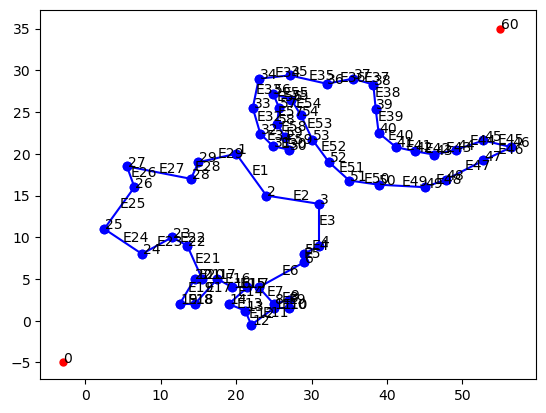

In [191]:
def plot_env(vertexs, edges): 
    
    for vertex in vertexs:
        plt.scatter(vertex.p.x, vertex.p.y, s=100, c='red', marker='.')
        plt.annotate(vertex.id, (vertex.p.x+0.1, vertex.p.y))
        
   
    for edge in edges:
        plt.plot([edge.p1.x , edge.p2.x], [edge.p1.y ,edge.p2.y], 'bo', linestyle="-")
        plt.annotate("E"+str(edge.id), ((edge.p1.x+edge.p2.x)/2, (edge.p1.y+edge.p2.y)/2))
        

plot_env(vertexs,edges)




- RPS 

In [192]:
time_start = time.time()
RPS = RotationalPlaneSweep()
result,v_result = RPS.rotational_plane_sweep(vertexs.copy(),edges.copy(),polygons)
time_used = time.time()-time_start


Vertex sequence:['v12', 'v10', 'v11', 'v9', 'v8', 'v13', 'v14', 'v7', 'v15', 'v6', 'v16', 'v18', 'v5', 'v4', 'v48', 'v46', 'v47', 'v49', 'v19', 'v45', 'v17', 'v44', 'v43', 'v50', 'v21', 'v42', 'v3', 'v20', 'v51', 'v41', 'v40', 'v52', 'v60', 'v39', 'v2', 'v53', 'v38', 'v22', 'v30', 'v37', 'v59', 'v31', 'v54', 'v36', 'v58', 'v23', 'v55', 'v32', 'v57', 'v1', 'v35', 'v56', 'v33', 'v24', 'v28', 'v34', 'v29', 'v26', 'v27', 'v25']
Initial S list:[]
--------------------------------------------------
V0 ---> V12
--------------------------------------------------
S List before update:[]
 --> ADD E11
 --> ADD E12
S List before sort:[11, 12]
S List after sort:[11, 12]
no intersect with first of s list
add (v0, v12)
--------------------------------------------------
V0 ---> V10
--------------------------------------------------
S List before update:[11, 12]
 --> ADD E9
 --> ADD E10
S List before sort:[11, 12, 9, 10]
S List after sort:[12, 11, 9, 10]
intersect with first of s list
(v0, v10) is not v

The visability graph of this environment is:
RPS use 0.30507874488830566 s to solve the path


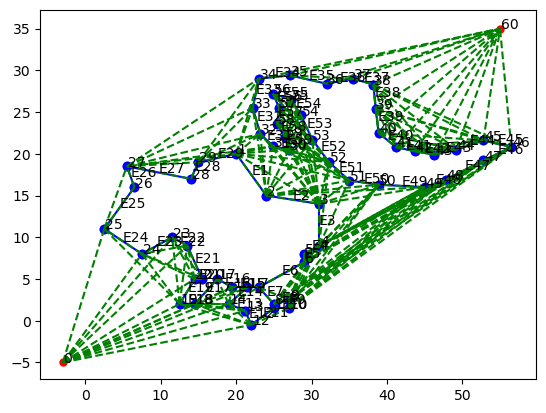

In [193]:
plot_env(vertexs,edges)

for edge in result:
        plt.plot([edge.p1.x , edge.p2.x], [edge.p1.y ,edge.p2.y], 'g', linestyle="--")

print("The visability graph of this environment is:")
print(v_result)
print("RPS use {} s to solve the path".format(time_used) )

- Brute Force

In [194]:
time_start = time.time()
BF = BruteForce()
result_bf , v_result_bf = BF.brute_force(vertexs.copy(),edges.copy(),polygons)
time_used = time.time()-time_start

Terminal edge -- no edges
add (v0, v12)
Terminal edge -- no edges


The visability graph of this environment is:
Brute Force use 4.459308385848999 s to solve the path


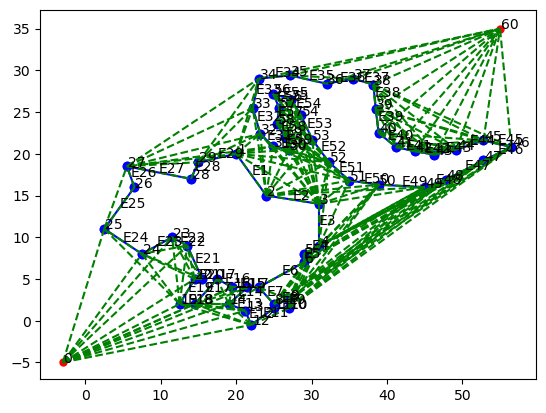

In [195]:
plot_env(vertexs,edges)

for edge in result_bf:
        plt.plot([edge.p1.x , edge.p2.x], [edge.p1.y ,edge.p2.y], 'g', linestyle="--")
        
print("The visability graph of this environment is:")
print(v_result_bf)
print("Brute Force use {} s to solve the path".format(time_used) )